In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import load_model

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23848\2391788936.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
# Avoid OOM errors by setting GPU Memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for fpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

Remove dodgy images

In [3]:
dataset = 'dataset'

In [4]:
image_exts = ['jpeg','jpg','bmp','png']

In [5]:
image_exts[2]

'bmp'

In [6]:
for image_class in os.listdir(dataset):
    for img in os.listdir(os.path.join(dataset,image_class)):
        image_path = os.path.join(dataset,image_class, img)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('image not in ext list{}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('issue with image{}'.format(image_path))

Load Data

In [7]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [8]:
data = tf.keras.utils.image_dataset_from_directory('dataset')

Found 1779 files belonging to 2 classes.


In [9]:
data_iterator = data.as_numpy_iterator()

In [10]:
#get another batch from the iterator
batch = data_iterator.next()

In [11]:
#Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [12]:
# class 1 = Phishing, class 0 = Non-Phishing
batch[1]

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1])

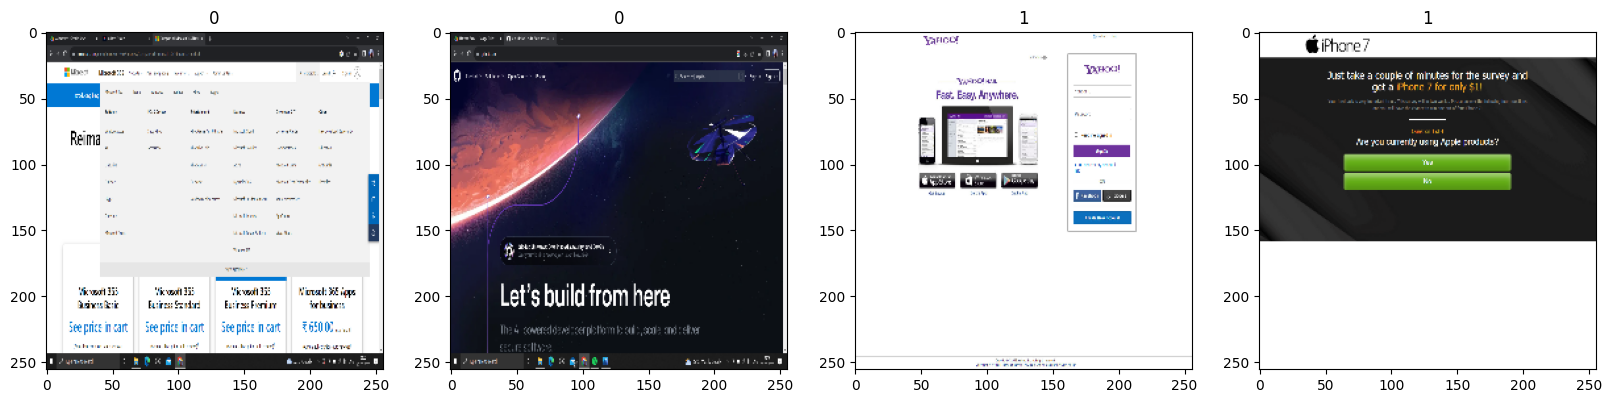

In [13]:
fig, ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [14]:
scaled = batch[0] / 255

In [15]:
scaled.max()

1.0

2.Preprocess Data

2.1 Scale Data

In [16]:
data = data.map(lambda x, y:(x/255,y))

In [17]:
scaled_iterator = data.as_numpy_iterator()

In [18]:
batch = scaled_iterator.next()

In [19]:
batch[0].max()

1.0

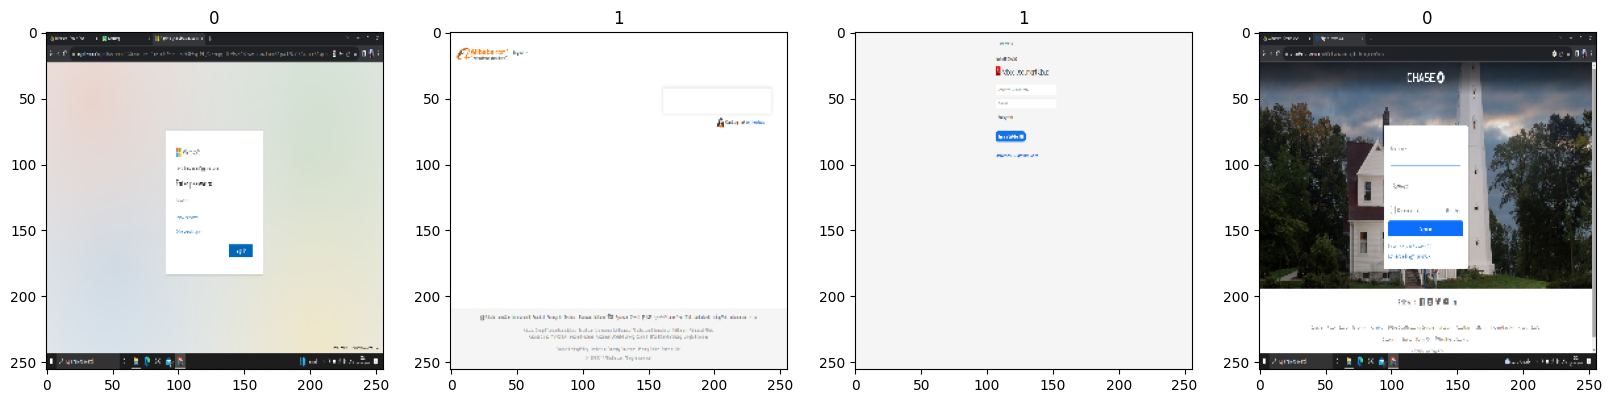

In [20]:
fig, ax =plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 Split Data

In [21]:
len(data)

56

In [22]:
56*.7

39.199999999999996

In [23]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [24]:
train_size+test_size+val_size

56

In [25]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [26]:
len(train)

39

3.1 Build Deap Learning Model

In [27]:
model = Sequential()

In [28]:
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
39/39 [==============================] - 60s 1s/step - loss: 0.3337 - accuracy: 0.8638 - val_loss: 0.0536 - val_accuracy: 0.9886
Epoch 2/20
39/39 [==============================] - 53s 1s/step - loss: 0.0355 - accuracy: 0.9928 - val_loss: 0.0212 - val_accuracy: 0.9915
Epoch 3/20
39/39 [==============================] - 59s 1s/step - loss: 0.0231 - accuracy: 0.9936 - val_loss: 0.0120 - val_accuracy: 0.9972
Epoch 4/20
39/39 [==============================] - 52s 1s/step - loss: 0.0125 - accuracy: 0.9976 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 5/20
39/39 [==============================] - 48s 1s/step - loss: 0.0113 - accuracy: 0.9968 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 6/20
39/39 [==============================] - 47s 1s/step - loss: 0.0094 - accuracy: 0.9984 - val_loss: 0.0412 - val_accuracy: 0.9886
Epoch 7/20
39/39 [==============================] - 48s 1s/step - loss: 0.0110 - accuracy: 0.9952 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 8/20
39/39 [==

3.3 PLt Performance

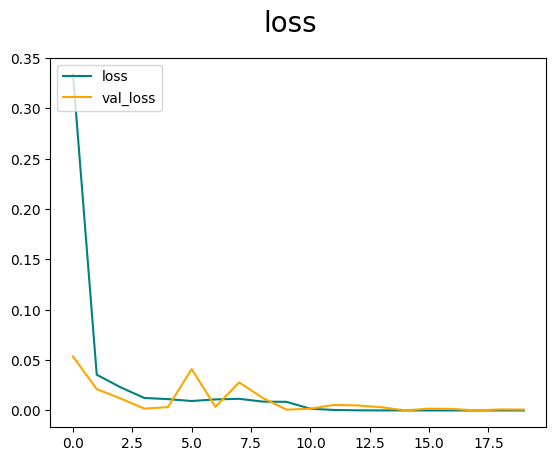

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='val_loss')
fig.suptitle('loss',fontsize=20)
plt.legend(loc="upper left")
plt.show()

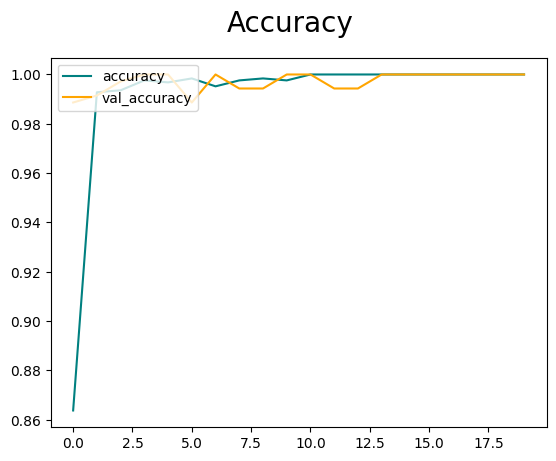

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='val_accuracy')
fig.suptitle('Accuracy',fontsize=20)
plt.legend(loc="upper left")
plt.show()

4. Evaluate Performance

4.1 Evaluate

In [35]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
len(test)

6

In [37]:
for batch in test.as_numpy_iterator():
    x, y = batch
    yhat = model.predict(x)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 134ms/step


In [38]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


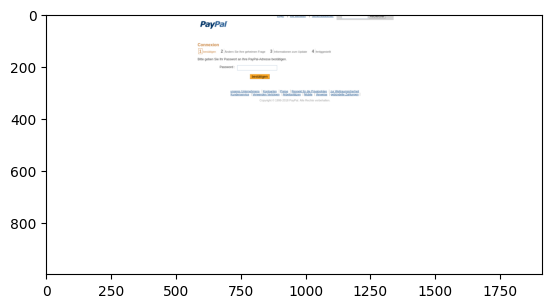

In [39]:
img = cv2.imread('p5.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

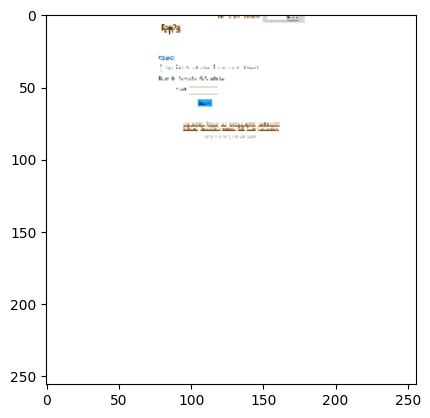

In [40]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [41]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 33ms/step


In [42]:
yhat

array([[0.9999866]], dtype=float32)

In [43]:
if yhat < 0.8:
    print(f'Predicted Website is Safe')
else:
    print(f'Predicted Website is Phishing')

Predicted Website is Phishing


5. Save the Model

In [44]:
model.save(os.path.join('model','Phishing-Image-Detection.h5'))

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [45]:
new_model = load_model(os.path.join('model','Phishing-Image-Detection.h5'))

In [46]:
yhatnew = new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 75ms/step


In [47]:
if yhatnew < 0.5:
    print(f'Predicted Website is Safe')
else:
    print(f'Predicted Website is Phishing')

Predicted Website is Phishing
